In [9]:
import numpy as np
import pandas as pd




#------------------------- Feature Engineering -------------------------#

compas_scores_two_year= pd.read_csv("compas_scores_two_years.csv",  lineterminator='\n')

# Select features from dataset
df= compas_scores_two_year[[ 'juv_fel_count', 'juv_misd_count', 'juv_other_count' ,'age', 'c_charge_degree','race', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',  'c_jail_in', 'c_jail_out',  'v_decile_score','two_year_recid\r']]
# Process the data
df = df.loc[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) & (df['is_recid'] != -1) & (df['c_charge_degree'] != 'O') & (df['score_text'] != 'N/A')]
#length of stay in jail 
df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].astype('timedelta64[D]')
df['length_of_stay'] = df['length_of_stay'].astype(int)

#------------------------- Data Preprocessing -------------------------#
#split into caucasian and non-caucasian

df_CC = df.loc[df['race'] == 'Caucasian']
print('Caucasian', np.shape(df_CC))
df_AA = df.loc[df['race'] == 'African-American']
print('African-American', np.shape(df_AA))

df_NC = df.loc[df['race'] != 'Caucasian']

#equalizing odds 

def equilizing_odds(C):
    # #convert to probability
    # C = (1/len(F_true_score))*C
    # print(C)

    # False postive rates :Pr[ ˆY = 1/S = 1, Y = 0] − Pr[ ˆY = 0/S = 0, Y = 0]
    # False negative rates :Pr[ ˆY = 1/S = 1, Y = 1] − Pr[ ˆY = 0/S = 0, Y = 1]
    
    FNR = abs(C[0][0,1]/(C[0][0,1]+C[0][0,0]) - C[1][0,1]/(C[1][0,1]+C[1][0,0]))
    FPR = abs(C[0][1,0]/(C[0][1,0]+C[0][1,1]) - C[1][1,0]/(C[1][1,0]+C[1][1,1]))

    result = [FPR, FNR]

    return result



#------------------------- create factors  -------------------------#

           

def factoration (df_x):
    def length_factoration (df_x):
        df= df_x
        #length of stay in jail 
        df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
        df['length_of_stay'] = df['length_of_stay'].astype('timedelta64[D]')
        df['length_of_stay'] = df['length_of_stay'].astype(int)

        days = []
        weeks = []
        months = []
        years = []

        for length in df['length_of_stay']:
            if length<7:
                days.append(1)
                weeks.append(0)
                months.append(0)
                years.append(0)
            elif (length<30):
                days.append(0)
                weeks.append(1)
                months.append(0)
                years.append(0)
            elif length<365:
                days.append(0)
                weeks.append(0)
                months.append(1)
                years.append(0)
            else:
                days.append(0)
                weeks.append(0)
                months.append(0)
                years.append(1)

        return days, weeks, months, years

    def jail_factoration (df_x):
        jail_feature = []
        jail_feature_squared = []
        for jail in df['length_of_stay']:
            if(jail/365) > 1:
                jail_feature.append(1)
                jail_feature_squared.append((1)**2)
            else:
                jail_feature.append(jail/365)
                jail_feature_squared.append((jail/365)**2)
        return jail_feature, jail_feature_squared
  
    def age_factoration (df_x):
    
        df= df_x
        df_age = df['age'].astype(int)

        twenties_and_less = []
        thirties=[]
        fourties=[]
        fifties_and_more=[]

        for age in df_age:
            if age<30:
                twenties_and_less.append(1)
                thirties.append(0)
                fourties.append(0)
                fifties_and_more.append(0)
            elif age<40:
                twenties_and_less.append(0)
                thirties.append(1)
                fourties.append(0)
                fifties_and_more.append(0)
            elif age<50:
                twenties_and_less.append(0)
                thirties.append(0)
                fourties.append(1)
                fifties_and_more.append(0)
            else:
                twenties_and_less.append(0)
                thirties.append(0)
                fourties.append(0)
                fifties_and_more.append(1)

        return twenties_and_less, thirties, fourties, fifties_and_more
    
    def age_featrure (df_x):
        df= df_x
        df_age = df['age'].astype(int)
        mean_age = df_age.mean()
        age_feature_squared = []
        age_feature = []
        for age in df_age:
            if(age/mean_age) > 2:
                age_feature.append(2)
                age_feature_squared.append((2)**2)
            else:
                age_feature.append(age/mean_age)
                age_feature_squared.append((age/mean_age)**2)
        return age_feature, age_feature_squared

    def crime_factoration (df_x):
        df= df_x
        df_c_charge_degree = df[['c_charge_degree']] 
        crime_factor, u_charge_degree = pd.factorize(df_c_charge_degree['c_charge_degree'])
        return crime_factor

    def gender_factoration (df_x):
        df= df_x
        # Gender
        male = []
        female = []
        for gender in df['sex']:
            if gender == "Male":
                male.append(1)
                female.append(0)
            else:
                male.append(0)
                female.append(1)

        return male, female
    

    def priors_factoration (df_x):
        df= df_x
        
        # # Prior convictions
        juvinile_felonies  = df[['juv_fel_count']].astype(int)
        juvinile_misconduct  = df[['juv_misd_count']].astype(int)
        juvinile_other  = df[['juv_other_count']].astype(int)
        return juvinile_felonies, juvinile_misconduct, juvinile_other

    def prior_conviction_factoration (df_x):
        priors_count  = df['priors_count'].astype(int)
        no_prior_convictions = []
        one_prior =[]
        multiple_prior = []
        many_prior = []

        # Prior Convictions Feature
        for prior in priors_count:
            if prior==0:
                one_prior.append(0)
                multiple_prior.append(0)
                many_prior.append(0)
                no_prior_convictions.append(1)
            elif prior<2:
                one_prior.append(1)
                multiple_prior.append(0)
                many_prior.append(0)
                no_prior_convictions.append(0)
            elif prior<5:
                one_prior.append(0)
                multiple_prior.append(1)
                many_prior.append(0)
                no_prior_convictions.append(0)
            else:
                one_prior.append(0)
                multiple_prior.append(0)
                many_prior.append(1)
                no_prior_convictions.append(0)
        return no_prior_convictions, one_prior, multiple_prior, many_prior

    df= df_x
    #length factors 
    quick_stay, short_stay, medium_stay, long_stay = length_factoration(df)
    #age factors
    twenties_and_less, thirties, fourties, fifties_and_more = age_factoration(df)
    #charge factors
    crime_factor = crime_factoration(df)
    #gender factors
    male, non_male = gender_factoration(df)
    #priors factors
    juvinile_felonies, juvinile_misconduct, juvinile_other = priors_factoration(df)
    #prior convictions factors
    no_prior_convictions, one_prior, multiple_prior, many_prior = prior_conviction_factoration(df)
    #jail factors
    jail_feature, jail_feature_squared = jail_factoration(df)
    #age factors
    age_feature, age_feature_squared = age_featrure(df)

    X = np.column_stack((quick_stay, short_stay, medium_stay, long_stay, twenties_and_less, thirties, fourties, fifties_and_more, crime_factor, male, non_male, juvinile_felonies, juvinile_misconduct, juvinile_other, no_prior_convictions, one_prior, multiple_prior, many_prior, jail_feature, jail_feature_squared, age_feature, age_feature_squared))
    return X


data_CC = factoration(df_CC)
data_AA = factoration(df_NC)
X = factoration(df)

# labels 
def labels(df_x):
    df= df_x
    compas_score = []
    for score in df['decile_score']:
        if score<5:
            compas_score.append(0)
        else:
            compas_score.append(1)
    two_year_recid = df[['two_year_recid\r']].astype(int)

    return compas_score, two_year_recid

compas_score_CC, recid_CC = labels(df_CC)
compas_score_AA, recid_AA = labels(df_NC)
compas_score, two_year_recid = labels(df)


#------ split into train and test sets
from sklearn.model_selection import train_test_split
X_train_CC, X_test_CC, y_train_CC, y_test_CC = train_test_split(data_CC, compas_score_CC, test_size=0.2, random_state=0)
X_train_AA, X_test_AA, y_train_AA, y_test_AA = train_test_split(data_AA, compas_score_AA, test_size=0.2, random_state=0)

X_train_CC_recide, X_test_CC_recide, y_train_CC_recide, y_test_CC_recide = train_test_split(data_CC, recid_CC, test_size=0.2, random_state=0)
X_train_AA_recide, X_test_AA_recide, y_train_AA_recide, y_test_AA_recide = train_test_split(data_AA, recid_AA, test_size=0.2, random_state=0)

# loop to increa 

# --------- logistic regression --------------#

from sklearn.linear_model import LogisticRegression
#Logistic Regression model for CC
logreg = LogisticRegression()
logreg.fit(X_train_CC, np.ravel(y_train_CC))
y_pred_CC = logreg.predict(X_test_CC)

#Logistic Regression model for AA
#Optimal C = 1
logreg = LogisticRegression(penalty='l2', C=10)
logreg.fit(X_train_AA, np.ravel(y_train_AA))
y_pred_AA = logreg.predict(X_test_AA)


from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_AA_recide, y_pred_AA ), confusion_matrix(y_test_CC_recide, y_pred_CC )

print('----------------------------------------------------')
print('------ Equlizing odds with Logistic Regression ------')
print('equlizing odds',equilizing_odds(C))
print('differnce in equlizing odds',equilizing_odds(C)[0]-equilizing_odds(C)[1])
# accuracy
from sklearn.metrics import accuracy_score
print('accuracy African AMericans', accuracy_score(y_test_AA, y_pred_AA))
print('accuracy Caucasians', accuracy_score(y_test_CC, y_pred_CC))


from sklearn.neighbors import KNeighborsClassifier
#KNN model for CC
knn = KNeighborsClassifier(n_neighbors = 45)
knn.fit(X_train_CC, np.ravel(y_train_CC))
y_pred_CC = knn.predict(X_test_CC)

#KNN model for AA
knn = KNeighborsClassifier(n_neighbors = 45)
knn.fit(X_train_AA, np.ravel(y_train_AA))
y_pred_AA = knn.predict(X_test_AA)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_AA_recide, y_pred_AA ), confusion_matrix(y_test_CC_recide, y_pred_CC )

print('----------------------------------------------------')
print('------ Equlizing odds with KNN ------')
print('equlizing odds',equilizing_odds(C))
print('differnce in equlizing odds',equilizing_odds(C)[0]-equilizing_odds(C)[1])
# accuracy
from sklearn.metrics import accuracy_score
print('accuracy African AMericans', accuracy_score(y_test_AA, y_pred_AA))
print('accuracy Caucasians', accuracy_score(y_test_CC, y_pred_CC))



#------------------------- SVM model -------------------------#

from sklearn.svm import SVC
#SVM model for CC
svm = SVC(kernel = 'linear', C = 1)
svm.fit(X_train_CC, np.ravel(y_train_CC))
y_pred_CC = svm.predict(X_test_CC)

#SVM model for AA
svm = SVC(kernel = 'linear', C = 1)
svm.fit(X_train_AA, np.ravel(y_train_AA))
y_pred_AA = svm.predict(X_test_AA)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_AA_recide, y_pred_AA ), confusion_matrix(y_test_CC_recide, y_pred_CC )

print('----------------------------------------------------')
print('------ Equlizing odds with SVM ------')
print('equlizing odds',equilizing_odds(C))
print('differnce in equlizing odds',equilizing_odds(C)[0]-equilizing_odds(C)[1])
# accuracy
from sklearn.metrics import accuracy_score
print('accuracy African AMericans', accuracy_score(y_test_AA, y_pred_AA))
print('accuracy Caucasians', accuracy_score(y_test_CC, y_pred_CC))


#-------------------------  MLP Model  -------------------------#

from sklearn.neural_network import MLPClassifier
#MLP model for CC
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000)
model.fit(X_train_CC, np.ravel(y_train_CC))
y_pred_CC = model.predict(X_test_CC)

#MLP model for AA
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000)
model.fit(X_train_AA, np.ravel(y_train_AA))
y_pred_AA = model.predict(X_test_AA)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_AA_recide, y_pred_AA ), confusion_matrix(y_test_CC_recide, y_pred_CC )

print('----------------------------------------------------')
print('------ Equlizing odds with MLP ------')
print('equlizing odds',equilizing_odds(C))
print('differnce in equlizing odds',equilizing_odds(C)[0]-equilizing_odds(C)[1])
# accuracy
from sklearn.metrics import accuracy_score
print('accuracy African AMericans', accuracy_score(y_test_AA, y_pred_AA))
print('accuracy Caucasians', accuracy_score(y_test_CC, y_pred_CC))

Caucasian (2103, 17)
African-American (3175, 17)
----------------------------------------------------
------ Equlizing odds with Logistic Regression ------
equlizing odds [0.2595581768327383, 0.12577629095899812]
differnce in equlizing odds 0.13378188587374018
accuracy African AMericans 0.7346437346437347
accuracy Caucasians 0.7648456057007126


C:\Users\lukej\AppData\Local\Temp\ipykernel_9512\3952457578.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
C:\Users\lukej\AppData\Local\Temp\ipykernel_9512\3952457578.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length_of_stay'] = df['length_of_stay'].astype('timedelta64[D]')
C:\Users\lukej\AppData\Local\Temp\ipykernel_9512\3952457578.py:59: SettingWithCopyWarning: 
A value is trying to be set on a co

----------------------------------------------------
------ Equlizing odds with KNN ------
equlizing odds [0.32617655681445845, 0.1582261108251844]
differnce in equlizing odds 0.16795044598927406
accuracy African AMericans 0.7223587223587223
accuracy Caucasians 0.7600950118764845
----------------------------------------------------
------ Equlizing odds with SVM ------
equlizing odds [0.23820856398848017, 0.10851775604734945]
differnce in equlizing odds 0.12969080794113072
accuracy African AMericans 0.7223587223587223
accuracy Caucasians 0.7648456057007126
----------------------------------------------------
------ Equlizing odds with MLP ------
equlizing odds [0.2688533636849638, 0.13353920054897925]
differnce in equlizing odds 0.13531416313598457
accuracy African AMericans 0.726044226044226
accuracy Caucasians 0.7505938242280285


In [22]:
print ('shape of data_CC', y_pred_CC.shape)
print ('shape of data_CC', recid_CC.shape)


shape of data_CC (421,)
shape of data_CC (2103, 1)


-----------------size of train and test-----------------
X_train 4937
X_test 1235
y_train 4937
y_test 1235
-----------------coefficients with corresponding labels -----------------
Quick     -0.3739
Short     -0.0104
Medium     0.0281
Long     0.3564
20s     0.1474
30s     -0.1867
40s     -0.1205
50s+     0.16
Crime     -0.1799
Male     0.165
Female     -0.1648
Juvenile Felonies     0.1375
Juvenile Misconduct     0.1065
Juvenile Other     0.2622
No Prior Convictions     -0.739
One Prior Conviction     -0.3531
Multiple Prior Convictions     0.1894
Many Prior Convictions     0.9029
Jail Feature     -0.0137
Jail Feature Squared     0.1282
Age Feature     -0.5852
Age Feature Squared     -0.2834
-----------------intercept-----------------
[0.92937789]
-----------------score-----------------
0.6672
-----------------coefficients with corresponding labels -----------------
Quick     -0.6377
Short     0.0537
Medium     0.5313
Long     0.0524
20s     0.2539
30s     -0.2541
40s     -0.0925
50s+  

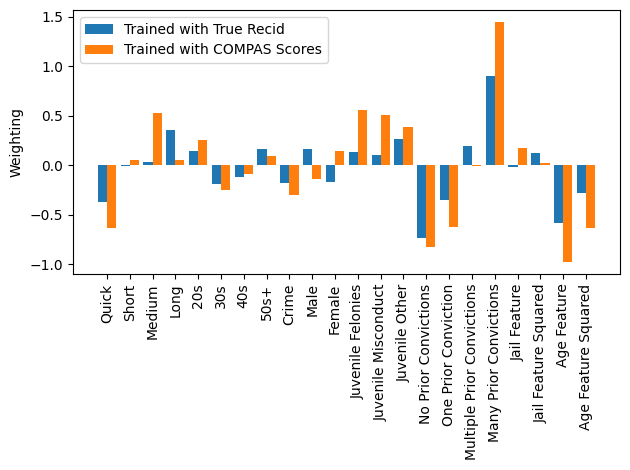

-----------------race split-----------------
African-American 0.5144199611147116
Caucasian 0.34073233959818533
Hispanic 0.08246921581335062
Asian 0.005022683084899547
Native American 0.0017822423849643552
Other 0.05557355800388853
-----------------Likelihood to re-offend----------------
low  3421
medium  1607
high  1144
-----------------Sex spread-----------------
race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285
-----------------decile score for african american-----------------
count    3175.000000
mean        5.276850
std         2.828073
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: decile_score, dtype: float64


In [12]:
x_lables = [ 'Quick', 'Short', 'Medium', 'Long', '20s', '30s', '40s', '50s+', 'Crime', 'Male', 'Female', 'Juvenile Felonies', 'Juvenile Misconduct', 'Juvenile Other', 'No Prior Convictions', 'One Prior Conviction', 'Multiple Prior Convictions', 'Many Prior Convictions', 'Jail Feature', 'Jail Feature Squared', 'Age Feature', 'Age Feature Squared']


#------------------------- Model Training -------------------------#

# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, two_year_recid, test_size=0.2, random_state=0)

# print size of train and test
print('-----------------size of train and test-----------------')
print('X_train', len(X_train))
print('X_test', len(X_test))
print('y_train', len(y_train))
print('y_test', len(y_test))

# logistic regression with true class
from sklearn.linear_model import LogisticRegression
model  = LogisticRegression(penalty='l2', C=0.1, max_iter=100)
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)

print('-----------------coefficients with corresponding labels -----------------')

coeff_true = model.coef_[0]
for i in range(len(x_lables)):
    print(x_lables[i], '   ', round( model.coef_[0][i], 4))


print('-----------------intercept-----------------')
print(model.intercept_)
print('-----------------score-----------------')
score_true = round(model.score(X_test, y_test),4)
print(score_true)

# logistic regression with predicted class
X_train, X_test, y_train, y_test = train_test_split(X, compas_score, test_size=0.2, random_state=0)
model  = LogisticRegression(penalty='l2', C=0.1, max_iter=100)
model.fit(X_train, np.ravel(y_train))
y_pred = model.predict(X_test)

print('-----------------coefficients with corresponding labels -----------------')
coeff_pred = model.coef_[0]
for i in range(len(x_lables)):
    print(x_lables[i], '   ', round( model.coef_[0][i], 4))
print('-----------------intercept (bias)-----------------')
print(model.intercept_)
print('-----------------score-----------------')
score_pre = round(model.score(X_test, y_test),4)
print(score_pre)


print('coeff_true', np.shape(coeff_true))

#-----------------View weigthing of coefficients ----------------


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.subplots(1,1)

X_axis = np.arange(len(x_lables))

plt.xticks(X_axis, x_lables, rotation=90)
ax.bar(X_axis - 0.2, coeff_true, 0.4, label='True class')
ax.bar(X_axis + 0.2, coeff_pred, 0.4, label='Predicted class')
ax.set_ylabel('Weighting')
# ax.set_title('Weighting of factors')
ax.legend(['Trained with True Recid', 'Trained with COMPAS Scores'])
plt.tight_layout()
plt.show()





# ----------------- To see interesting factors in data ----------------



print('-----------------race split-----------------')
race  = ['African-American', 'Caucasian', 'Hispanic', 'Asian', 'Native American', 'Other']
for i in race :
    print( i,len(df[df['race']== i])/len(df['race']))

# To see spread in re-offence rates
print ('-----------------Likelihood to re-offend----------------')
print('low ', len(df[df['score_text'] == 'Low']))
print('medium ', len(df[df['score_text'] == 'Medium']))
print('high ', len(df[df['score_text'] == 'High']))

print('-----------------Sex spread-----------------')
f = pd.crosstab(df['sex'], df['race'])
print(f)

# find decide score for african american
print('-----------------decile score for african american-----------------')
print(df[(df['race']) == 'African-American']['decile_score'].describe())
